In [ ]:
import matplotlib.pyplot as plt
import json
import os
from PIL import Image, ImageDraw
from IPython.display import display
from functools import partial
from multiprocessing.pool import Pool
from os import cpu_count

import cv2
from cv2 import fillPoly
from shapely import wkt
import numpy as np
from shapely.geometry import mapping
from tqdm import tqdm

In [ ]:
def generate_localization_polygon(json_path, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    with open(json_path, "r") as f:
        annotations = json.load(f)
    h = annotations["metadata"]["height"]
    w = annotations["metadata"]["width"]
    mask_img = np.zeros((h, w), np.uint8)
    out_filename = os.path.splitext(os.path.basename(json_path))[0] + ".png"
    for feat in annotations['features']['xy']:
        feat_shape = wkt.loads(feat['wkt'])
        coords = list(mapping(feat_shape)['coordinates'][0])
        fillPoly(mask_img, [np.array(coords, np.int32)], (255))
    cv2.imwrite(os.path.join(out_dir, out_filename), mask_img)

In [ ]:
def generate_damage_polygon(json_path, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    with open(json_path, "r") as f:
        annotations = json.load(f)

    h = annotations["metadata"]["height"]
    w = annotations["metadata"]["width"]
    mask_img = np.zeros((h, w), np.uint8)

    damage_dict = {
        "no-damage": 1,
        "minor-damage": 2,
        "major-damage": 3,
        "destroyed": 4,
        "un-classified": 1
    }
    out_filename = os.path.splitext(os.path.basename(json_path))[0] + ".png"
    for feat in annotations['features']['xy']:
        feat_shape = wkt.loads(feat['wkt'])
        coords = list(mapping(feat_shape)['coordinates'][0])
        fillPoly(mask_img, [np.array(coords, np.int32)], damage_dict[feat['properties']['subtype']])
    cv2.imwrite(os.path.join(out_dir, out_filename), mask_img)

In [ ]:
train_dirs =  ["/content/drive/MyDrive/train"]
    
for train_dir in train_dirs:
    out_dir = os.path.join(train_dir, "masks")
    in_dir = os.path.join(train_dir, "labels")
    pre_images = [os.path.join(in_dir, f) for f in os.listdir(in_dir) if '_pre_' in f]
    post_images = [os.path.join(in_dir, f) for f in os.listdir(in_dir) if '_post_' in f]

    pool = Pool(cpu_count())
    with tqdm(total=len(pre_images), desc='gen_pre_mask in {}'.format(train_dir)) as pbar:
        for i, v in enumerate(pool.imap_unordered(partial(generate_localization_polygon, out_dir=out_dir), pre_images)):
            pbar.update()
    with tqdm(total=len(post_images), desc='gen_post_mask in {}'.format(train_dir)) as pbar:
        for i, v in enumerate(pool.imap_unordered(partial(generate_damage_polygon, out_dir=out_dir), post_images)):
            pbar.update()

gen_post_mask in /content/drive/MyDrive/train: 100%|██████████| 2799/2799 [01:02<00:00, 45.09it/s]


In [ ]:
test_dirs =  ["/content/drive/MyDrive/test"]
    
for test_dir in test_dirs:
    out_dir = os.path.join(test_dir, "masks")
    in_dir = os.path.join(test_dir, "labels")
    pre_images = [os.path.join(in_dir, f) for f in os.listdir(in_dir) if '_pre_' in f]
    post_images = [os.path.join(in_dir, f) for f in os.listdir(in_dir) if '_post_' in f]

    pool = Pool(cpu_count())
    with tqdm(total=len(pre_images), desc='gen_pre_mask in {}'.format(test_dir)) as pbar:
        for i, v in enumerate(pool.imap_unordered(partial(generate_localization_polygon, out_dir=out_dir), pre_images)):
            pbar.update()
    with tqdm(total=len(post_images), desc='gen_post_mask in {}'.format(test_dir)) as pbar:
        for i, v in enumerate(pool.imap_unordered(partial(generate_damage_polygon, out_dir=out_dir), post_images)):
            pbar.update()

gen_post_mask in /content/drive/MyDrive/test: 100%|██████████| 933/933 [00:19<00:00, 47.37it/s]


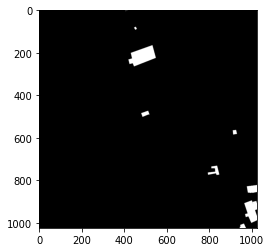

In [ ]:
train_pre_mask = plt.imread('/content/drive/MyDrive/train/masks/guatemala-volcano_00000000_pre_disaster.png')
plt.imshow(train_pre_mask, cmap='gray');

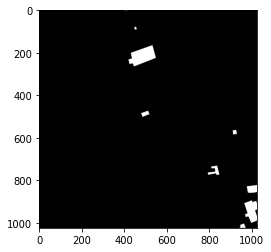

In [ ]:
train_post_mask = plt.imread('/content/drive/MyDrive/train/masks/guatemala-volcano_00000000_post_disaster.png')
plt.imshow(train_post_mask, cmap='gray');

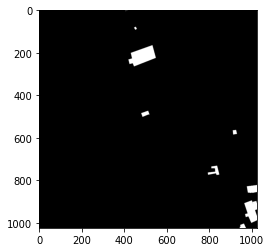

In [ ]:
test_pre_mask = plt.imread('/content/drive/MyDrive/test/masks/guatemala-volcano_00000003_post_disaster.png')
plt.imshow(train_pre_mask, cmap='gray');

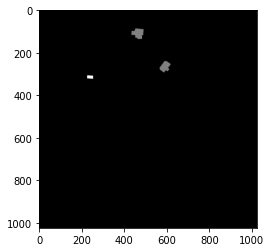

In [ ]:
test_post_mask = plt.imread('/content/drive/MyDrive/test/masks/guatemala-volcano_00000003_post_disaster.png')
plt.imshow(test_post_mask, cmap='gray');

In [ ]:
def show_polygons(img_path, json_path):
    with open(json_path, 'r', encoding='utf-8') as image_json_file:
        image_json = json.load(image_json_file)
    coords = image_json['features']['xy']

    polygons = []

    if(len(coords) != 0):
        for coord in coords:
            if 'subtype' in coord['properties']:
                damage = coord['properties']['subtype']
            else:
                damage = 'no-damage'
            polygons.append((damage, wkt.loads(coord['wkt'])))


    img = Image.open(img_path)
    draw = ImageDraw.Draw(img, 'RGBA')

    damage_dict = {
    "no-damage": (0, 255, 0, 125),
    "minor-damage": (255, 255, 0, 125),
    "major-damage": (255, 128, 0, 125),
    "destroyed": (255, 0, 0, 125),
    "un-classified": (0, 255, 0, 125)
    }

    for damage, polygon in polygons:
        x,y = polygon.exterior.coords.xy
        coords = list(zip(x,y))
        draw.polygon(coords, damage_dict[damage])

    del draw
    return img


/content/drive/MyDrive/train/images/socal-fire_00000598_post_disaster.png 
 /content/drive/MyDrive/train/labels/socal-fire_00000598_post_disaster.json


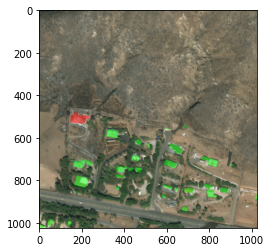

In [ ]:
train_dirs = ['/content/drive/MyDrive/train', '/content/drive/MyDrive/test']
all_files = []
for train in train_dirs:
    for f in os.listdir(os.path.join(train, 'images')):
        all_files.append(os.path.join(train, 'images', f))

img_path = all_files[1]
json_path = img_path.replace('/images/', '/labels/').replace('.png', '.json')

print(img_path, "\n", json_path)
  
try:
    mixed = show_polygons(img_path, json_path)
    plt.imshow(mixed)
except Exception as e:
    print(e)

In [ ]:
def start_points(size, split_size, overlap=0):
    points = [0]
    stride = int(split_size * (1-overlap))
    counter = 1
    while True:
        pt = stride * counter
        if pt + split_size >= size:
            points.append(size - split_size)
            break
        else:
            points.append(pt)
        counter += 1
    return points

def split_image_for_train(img_path, out_dir, overlap=0):
    out_image_dir = os.path.join(out_dir, 'images')
    os.makedirs(out_image_dir, exist_ok=True)
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    img_h, img_w, _= img.shape

    out_mask_dir = os.path.join(out_dir, 'masks')
    os.makedirs(out_mask_dir, exist_ok=True)
    mask_path = img_path.replace('images', 'masks')
    msk = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    msk_h, msk_w = msk.shape
    
    img_name = img_path.split('/')[-1]
    msk_name = mask_path.split('/')[-1]

    split_width = 256
    split_height = 256

    X_points = start_points(img_w, split_width, overlap=overlap)
    Y_points = start_points(img_h, split_height, overlap=overlap)

    count = 0

    for i in Y_points:
        for j in X_points:
            split_img = img[i:i+split_height, j:j+split_width]
            # print(os.path.join(out_dir, img_name.replace('.png', '_split_{}.png'.format(count))))
            cv2.imwrite(os.path.join(out_image_dir, img_name.replace('.png', '_split_{}.png'.format(count))), split_img, [cv2.IMWRITE_PNG_COMPRESSION, 9])

            split_msk = msk[i:i+split_height, j:j+split_width]
            cv2.imwrite(os.path.join(out_mask_dir, msk_name.replace('.png', '_split_{}.png'.format(count))), split_msk, [cv2.IMWRITE_PNG_COMPRESSION, 9])

            count += 1  


train_dirs = ['/content/drive/MyDrive/train']
out_dir = '/content/drive/MyDrive/train/split_data'

all_files = []
for train in train_dirs:
    for f in os.listdir(os.path.join(train, 'images')):
        all_files.append(os.path.join(train, 'images', f))

for img_path in tqdm(all_files, desc='split_images'):
    split_image_for_train(img_path=img_path, out_dir=out_dir) 

split_images: 100%|██████████| 5598/5598 [4:20:53<00:00,  2.80s/it]
